In [1]:
# ! pip install seaborn

# Задание 5.  Разведочный анализ данных (Exploratory Data Analysis, EDA) с использованием seaborn

## Цель задания
Научиться эффективно исследовать структуру данных, выявлять паттерны, корреляции и кластеризацию между объектами и признаками, а также строить сложные визуализации, такие как clustermap.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('../TestData/Task5_Food_Nutrition_Dataset.csv')

## 1.	Общая характеристика данных

In [4]:
print(data.shape)
rows = data.shape[0]
cols = data.shape[1]
data.head(5)

(205, 8)


,food_name,category,calories,protein,carbs,fat,iron,vitamin_c
0,"Apple, candied",Apples,134.0,1.34,29.61,2.15,0.12,3.6
1,"Apple, raw",Apples,61.0,0.17,14.80,0.15,0.03,4.6
2,"Apple, dried",Dried fruits,243.0,0.93,65.89,0.32,1.40,3.9
3,"Crisp, apple",Cakes and pies,215.0,2.81,30.18,9.59,1.00,0.6
4,"Apple, baked",Apples,113.0,0.32,22.70,3.08,0.19,3.9


In [5]:
data.sample(5)

,food_name,category,calories,protein,carbs,fat,iron,vitamin_c
0,"Apple, candied",Apples,134.0,1.34,29.61,2.15,0.12,3.6
162,"Tomatoes, fresh, cooked",Tomatoes,50.0,1.08,4.71,3.42,0.33,15.8
189,"Garlic, cooked",Mustard and other condiments,142.0,6.58,28.03,0.38,1.69,8.0
191,"Roll, garlic",Rolls and buns,309.0,10.84,51.92,6.44,3.71,0.2
148,"Sweet potato leaves, raw",Vegetables and Vegetable Products,175.0,2.49,8.82,0.51,0.97,11.0


In [6]:
data.columns.tolist()

['food_name',
 'category',
 'calories',
 'protein',
 'carbs',
 'fat',
 'iron',
 'vitamin_c']

Видим, что датасет содержит следующие столбцы

| Колонка    | Тип    | Описание                                                |
|------------|--------|----------------------------------------------------------|
| food_name  | Текстовый | Название/описание пищевого продукта (очищенное).        |
| category   | Категориальный | Категория продукта: фрукты, молочные, зерновые, мясо и др. |
| calories   | Числовой  | Энергетическая ценность на 100 г (Ккал).                 |
| protein    | Числовой  | Содержание белка в граммах.                              |
| carbs      | Числовой  | Содержание углеводов в граммах.                          |
| fat        | Числовой  | Общее содержание жиров в граммах.                        |
| iron       | Числовой  | Содержание железа (мг).                                  |
| vitamin_c  | Числовой  | Содержание витамина C (мг).                               |


In [7]:
# --- Определяем числовые и категориальные признаки ---
ignoring_cols = {'food_name'}

categorical_cols = {'category'}

numeric_cols = (set(data.columns.tolist()) - categorical_cols) - ignoring_cols

categorical_cols = list(categorical_cols)
numeric_cols = list(numeric_cols)
print(numeric_cols)

['iron', 'carbs', 'calories', 'protein', 'fat', 'vitamin_c']


## 2.	Анализ пропусков

In [8]:
data.isnull().sum()

food_name    0
category     0
calories     0
protein      0
carbs        0
fat          0
iron         2
vitamin_c    3
dtype: int64

In [9]:
hidden_nulls = ["", " ", "?", "N/A", "NA", "None"]

data.isin(hidden_nulls).sum()

food_name    0
category     0
calories     0
protein      0
carbs        0
fat          0
iron         0
vitamin_c    0
dtype: int64

In [10]:
(data[numeric_cols] < .0).sum()

iron         0
carbs        0
calories     0
protein      0
fat          0
vitamin_c    0
dtype: int64

Однако я заметил значения ''Not included in a food category'' в столбце 'category'. Являются отсутствием данных о категории еды - пропусками

In [11]:
print(data['category'].value_counts().to_string())

category
Fruits and Fruit Juices                             23
Vegetables and Vegetable Products                   17
Cakes and pies                                      12
Yeast breads                                        11
Beverages                                            8
Fried vegetables                                     7
Sweets                                               6
Pears                                                5
Baked Products                                       5
Dried fruits                                         5
Apples                                               4
Jams, syrups, toppings                               4
Tomatoes                                             4
Potato chips                                         4
Dips, gravies, other sauces                          4
Onions                                               4
Other fruit juice                                    4
Fast Foods                                           4
F

In [12]:
print(data['category'].value_counts()['Not included in a food category'] / rows * 100, '%')

0.975609756097561 %


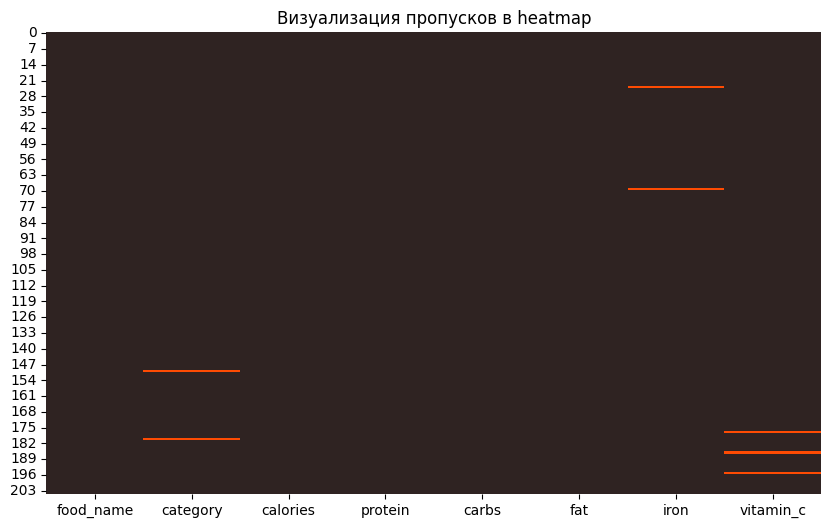

In [13]:
falsecmap = sns.dark_palette("xkcd:blood orange", n_colors=2)
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull()| data.isin(['Not included in a food category']), 
            cmap=falsecmap,  # можно 'magma', 'coolwarm' и др.
            cbar=False)       # убираем цветовую шкалу для наглядности

plt.title("Визуализация пропусков в heatmap")
plt.show()


Доля данны довольно маленькая (<10%).
Доля Пропусков во всех столбцах очень маленькая - меньше 2%. Так как в дальшейшем будем анализировать все столбцы - удалим все пропуски.

In [14]:
data.drop(data[data['category'] == 'Not included in a food category'].index, inplace=True)
data.dropna(inplace=True)
print(rows - data.shape[0])

7


In [15]:
rows = data.shape[0]

# 3.	Статистические оценки

In [16]:
# --- Статистика для числовых признаков ---
numeric_stats = data[numeric_cols].agg(
    ['mean', 'median', 'std', 'min', 'max']
).T

print("Числовые признаки — статистика:")
print(numeric_stats)


# --- Статистика для категориальных признаков ---
categorical_stats = {}

for col in categorical_cols:
    mode_value = data[col].mode()[0]
    value_counts = data[col].value_counts(dropna=False)
    
    categorical_stats[col] = {
        'mode': mode_value,
        'distribution': value_counts
    }

print("\nКатегориальные признаки — статистика:")
for col, stats in categorical_stats.items():
    print(f"\n{col}:")
    print("  Мода:", stats['mode'])
    print("  Распределение категорий:")
    print(stats['distribution'])

Числовые признаки — статистика:
                 mean   median         std    min      max
iron         0.841465    0.405    1.081497   0.00     9.09
carbs       25.717121   17.210   20.284058   1.79    85.13
calories   241.818182  169.500  274.086387  16.00  1460.00
protein      2.842323    1.800    3.330815   0.00    17.80
fat          6.049091    1.435    9.740942   0.00    74.02
vitamin_c   13.693939    7.050   18.665940   0.00   136.00

Категориальные признаки — статистика:

category:
  Мода: Fruits and Fruit Juices
  Распределение категорий:
category
Fruits and Fruit Juices                             22
Vegetables and Vegetable Products                   16
Cakes and pies                                      12
Yeast breads                                        11
Fried vegetables                                     7
Beverages                                            7
Sweets                                               6
Pears                                               

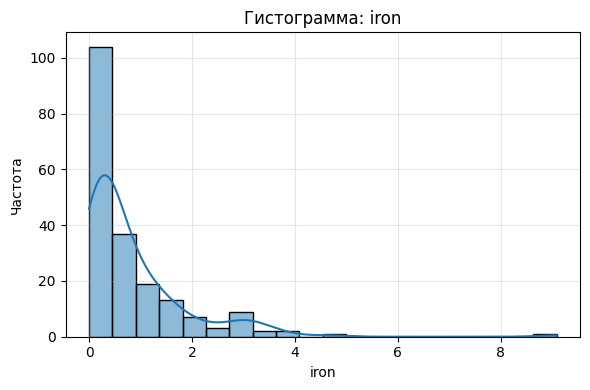

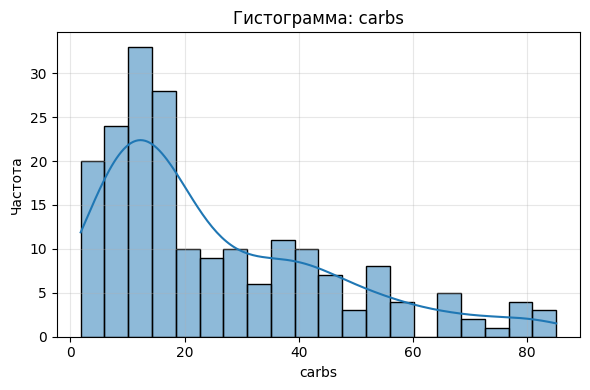

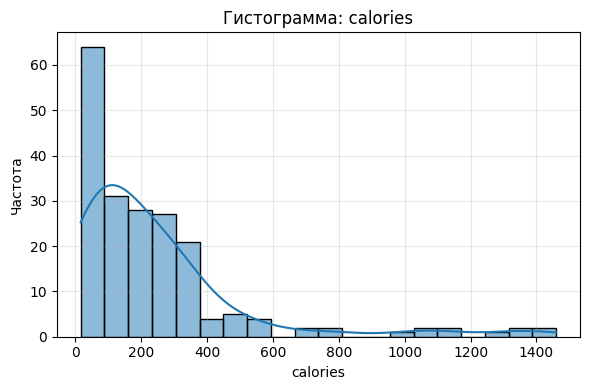

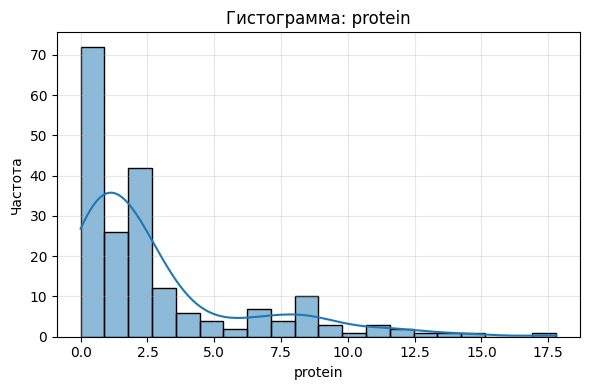

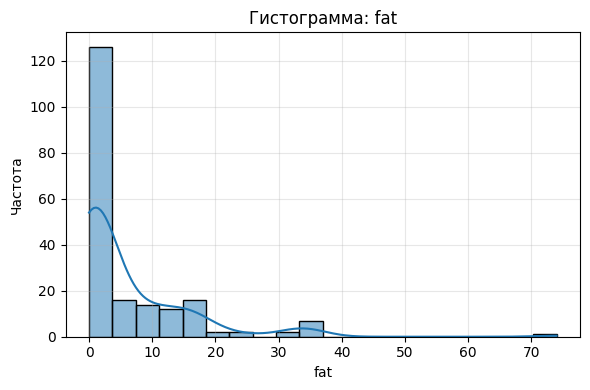

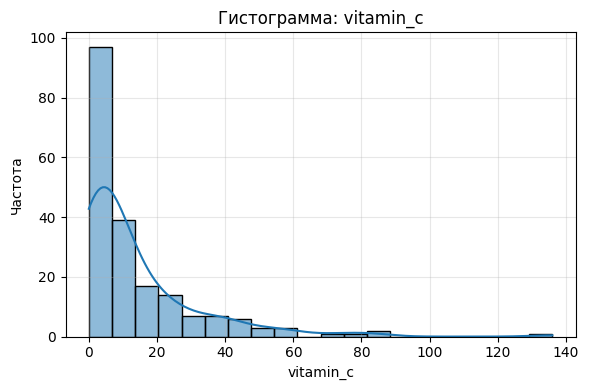

In [17]:
# --- Графики для числовых характеристик ---
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(
        data[col],
        bins=20,
        kde=True        # добавляем KDE
    )
    plt.title(f'Гистограмма: {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


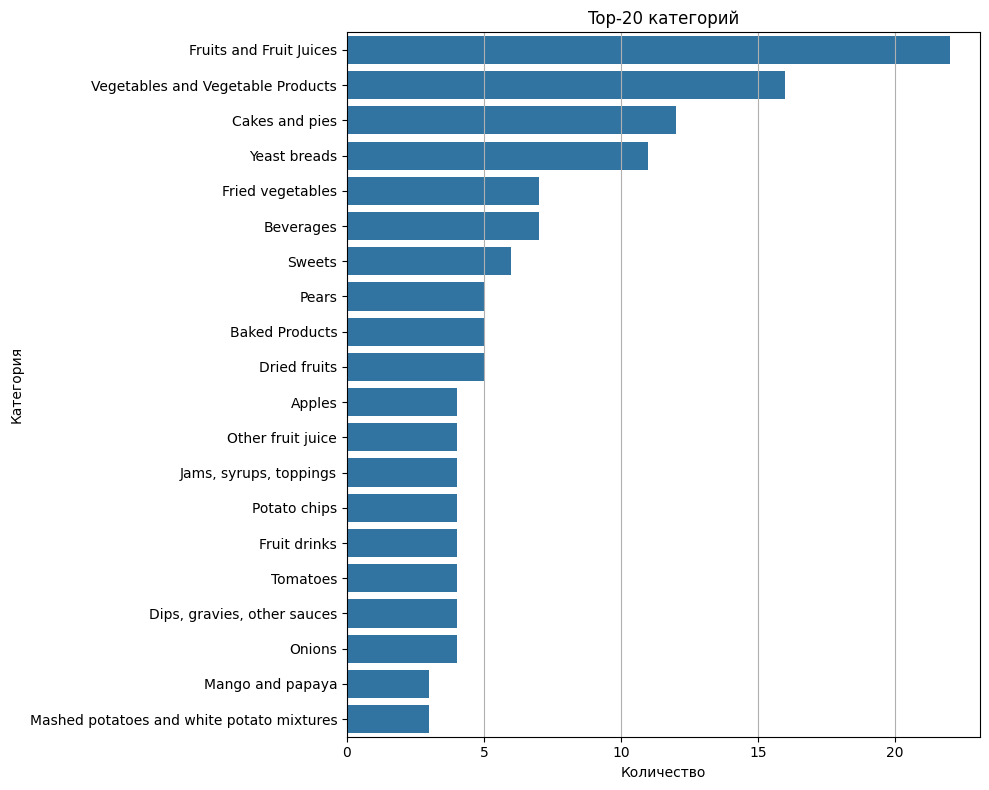

In [18]:
top_n = 20

top_categories = data["category"].value_counts().nlargest(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_categories.values, y=top_categories.index)

plt.title(f"Top-{top_n} категорий")
plt.xlabel("Количество")
plt.ylabel("Категория")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()

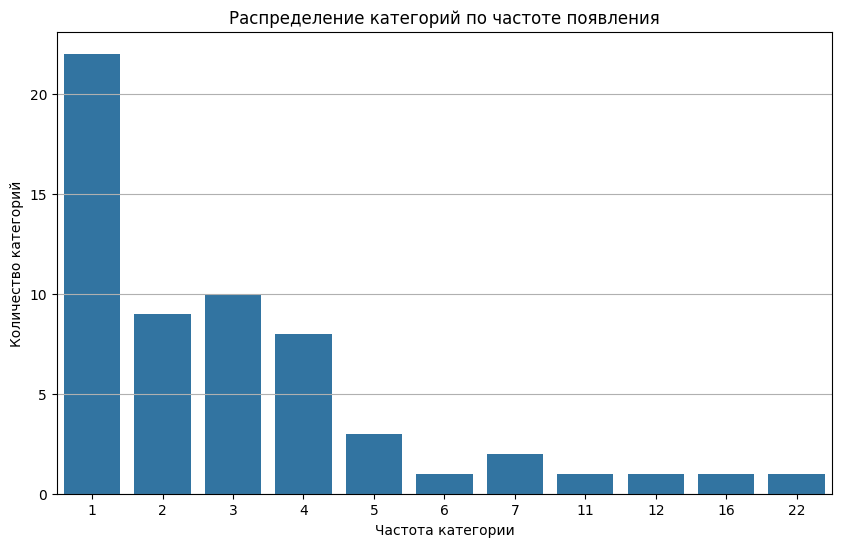

In [19]:
# Считаем, сколько раз каждая категория встречается
counts = data["category"].value_counts()

# Теперь считаем распределение этих частот
freq_of_freq = counts.value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=freq_of_freq.index, y=freq_of_freq.values)

plt.xlabel("Частота категории")
plt.ylabel("Количество категорий")
plt.title("Распределение категорий по частоте появления")
plt.grid(True, axis='y')
plt.show()


## 4.	Выявление аномалий (выбросов)

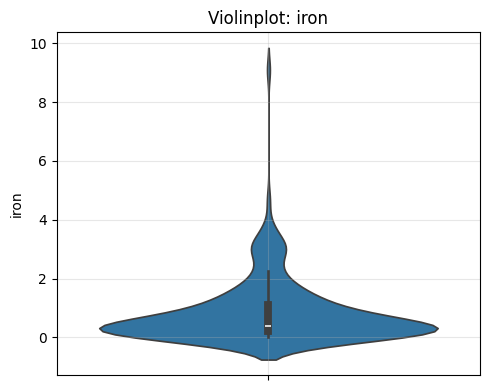

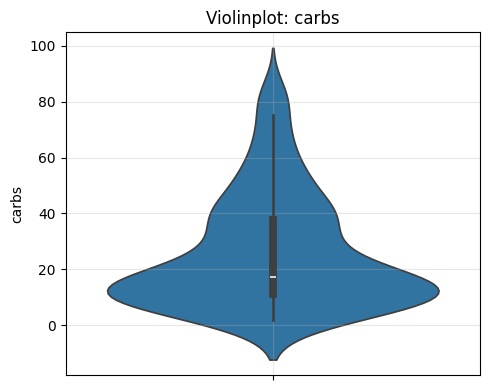

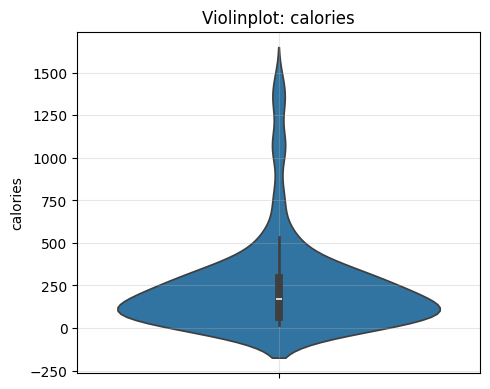

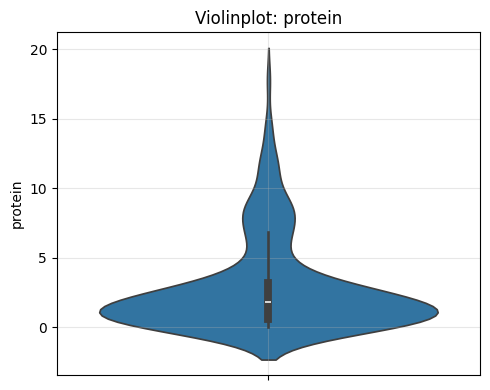

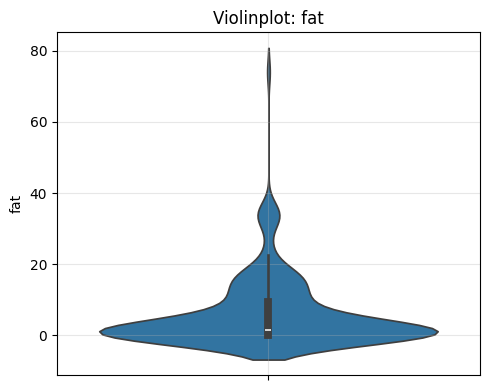

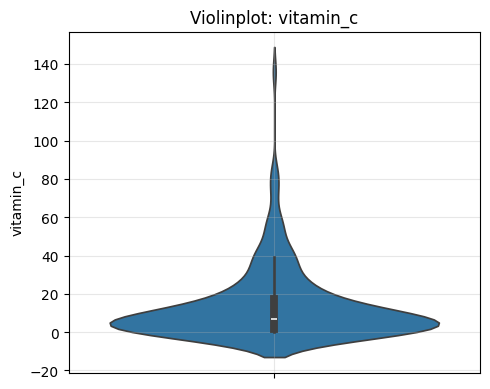

In [20]:
# Построение violinplot для каждого признака
for col in numeric_cols:
    plt.figure(figsize=(5, 4))
    sns.violinplot(y=data[col])
    plt.title(f'Violinplot: {col}')
    plt.ylabel(col)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Нереальных значений нет - выбросов нет.

## 5.	Визуализация с помощью seaborn

* countplot — для распределения категориального признака (с ≥20 категориями; при необходимости использовать поворот меток оси X).

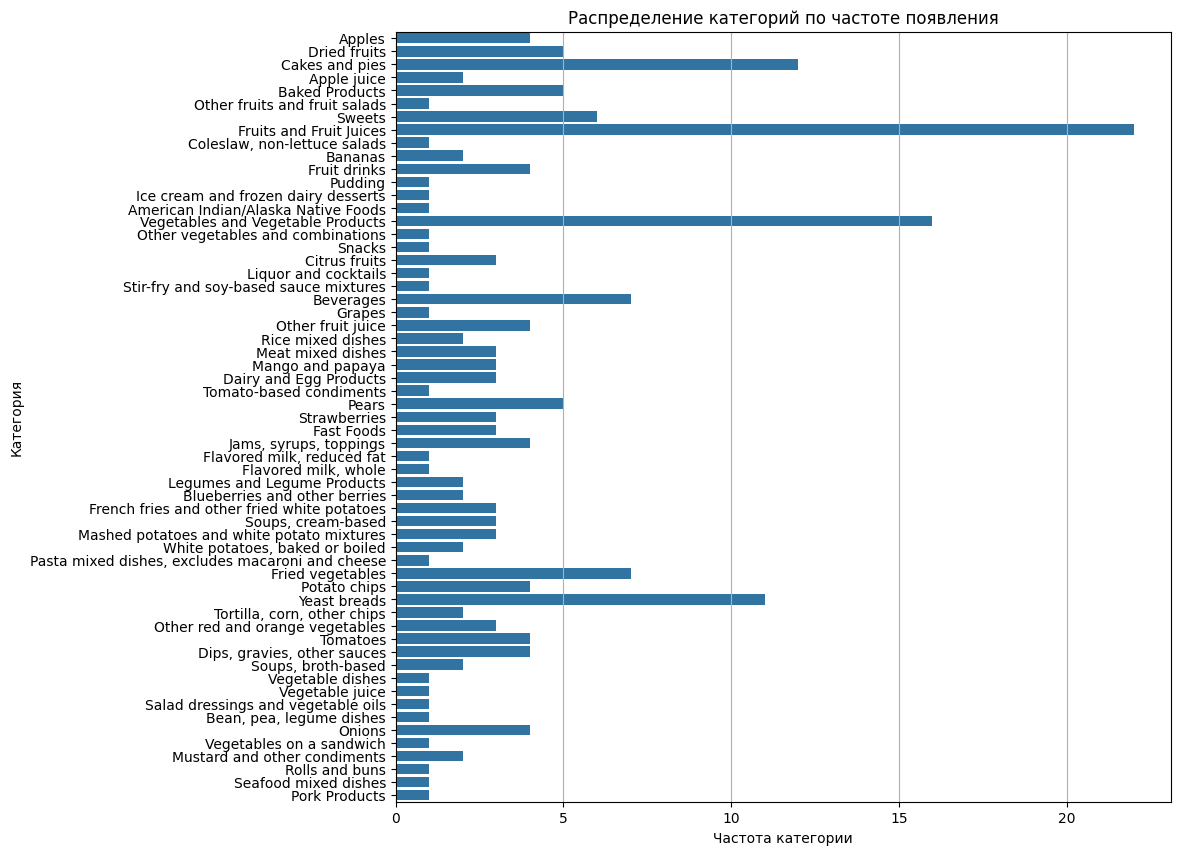

In [29]:
# Считаем, сколько раз каждая категория встречается
counts = data["category"].value_counts()

# Теперь считаем распределение этих частот
freq_of_freq = counts.value_counts().sort_index()

plt.figure(figsize=(10, 10))
sns.countplot(data = data["category"])

plt.xlabel("Частота категории")
plt.ylabel("Категория")
plt.title("Распределение категорий по частоте появления")
plt.grid(True, axis='x')
plt.show()

* histplot или kdeplot — для распределения числового признака.

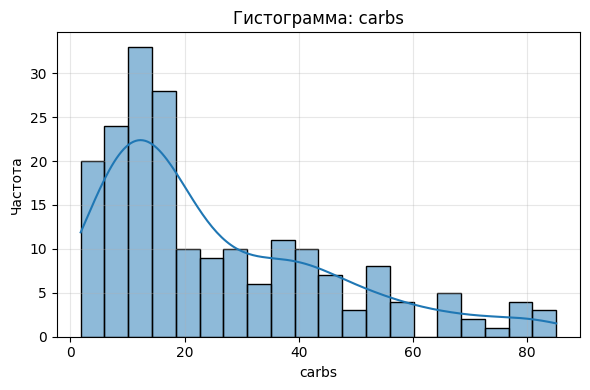

In [22]:
col = 'carbs'
plt.figure(figsize=(6, 4))
sns.histplot(
    data[col],
    bins=20,
    kde=True        # добавляем KDE
)
plt.title(f'Гистограмма: {col}')
plt.xlabel(col)
plt.ylabel('Частота')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

* scatterplot — с возможностью кодирования третьего признака цветом или размером (hue или size).

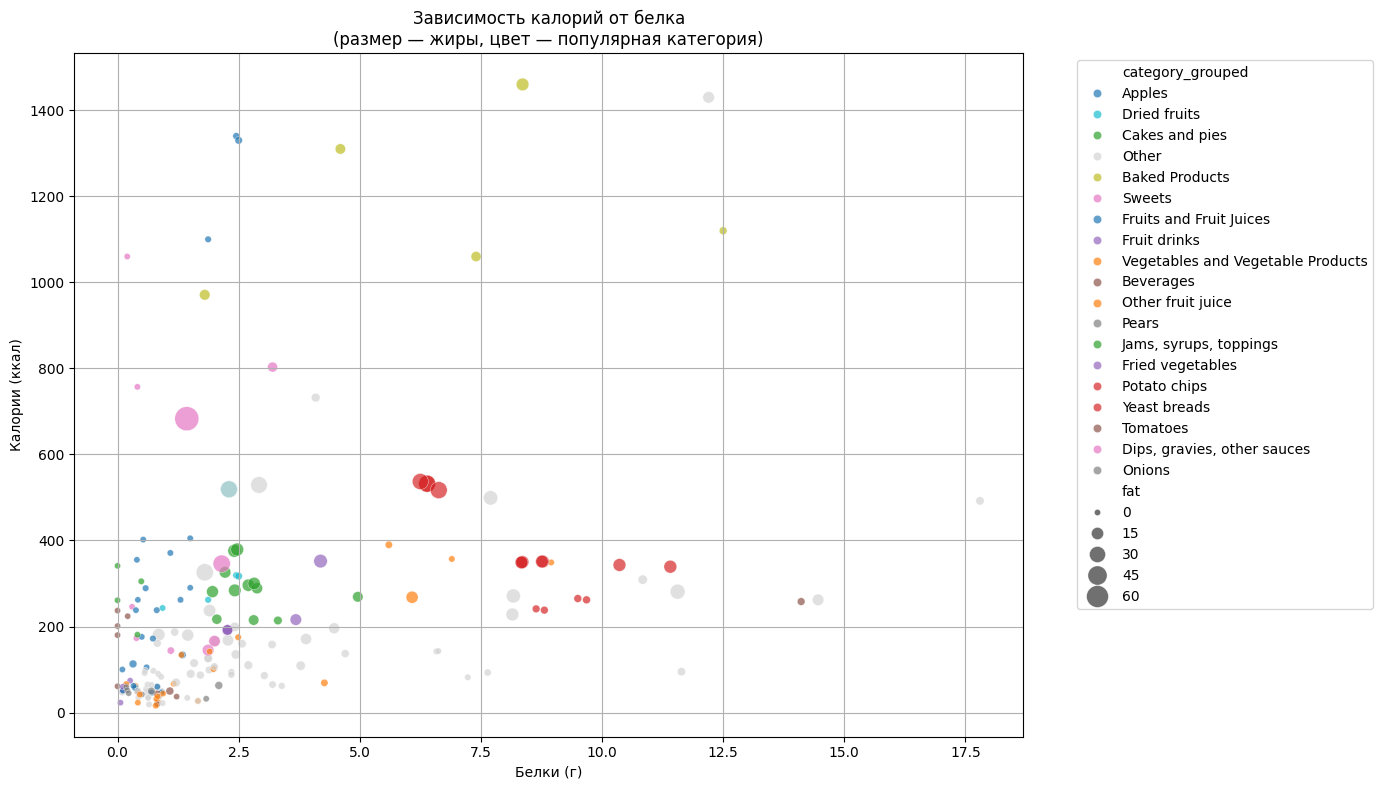

In [30]:
# Сделаем дополнительную колонку в которой будут только популярные категории

# порог частоты
n = 3  # например: показываем категории с >3 продуктами

# считаем частоты категорий
category_counts = data["category"].value_counts()

# категории, которые оставляем
major_categories = category_counts[category_counts > n].index

# создаём новую колонку с объединением редких категорий
data_plot = data.copy()
data_plot["category_grouped"] = np.where(
    data_plot["category"].isin(major_categories),
    data_plot["category"],
    "Other"
)

# формируем палитру: Other — серый
palette = {
    cat: color for cat, color in zip(
        major_categories,
        sns.color_palette("tab10", len(major_categories))
    )
}
palette["Other"] = "lightgray"

# scatterplot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=data_plot,
    x="protein",
    y="calories",
    size="fat",
    hue="category_grouped",
    palette=palette,
    sizes=(20, 300),
    alpha=0.7
)
plt.title("Зависимость калорий от белка\n(размер — жиры, цвет — популярная категория)")
plt.xlabel("Белки (г)")
plt.ylabel("Калории (ккал)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.grid(True)
plt.show()


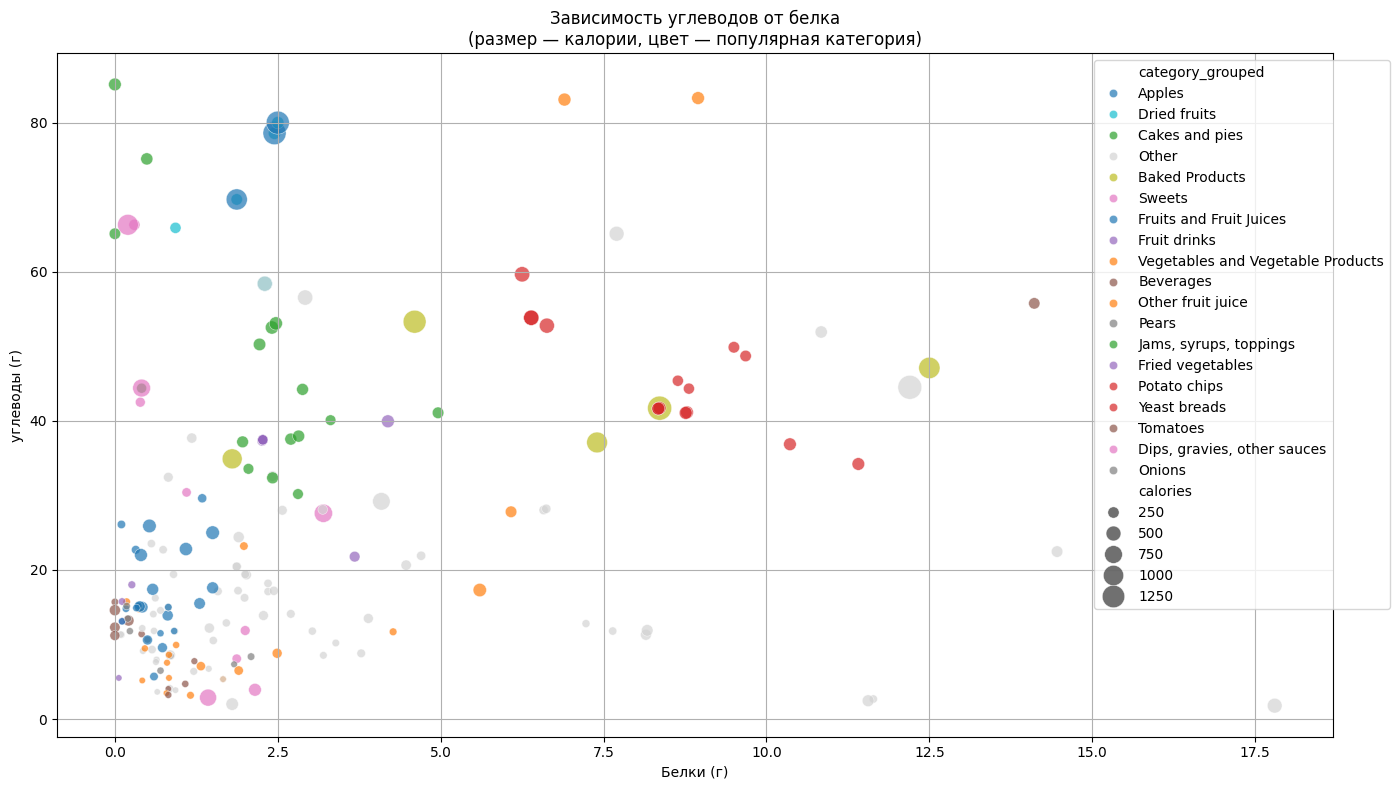

In [31]:
# Сделаем дополнительную колонку в которой будут только популярные категории

# порог частоты
n = 3  # например: показываем категории с >3 продуктами

# считаем частоты категорий
category_counts = data["category"].value_counts()

# категории, которые оставляем
major_categories = category_counts[category_counts > n].index

# создаём новую колонку с объединением редких категорий
data_plot = data.copy()
data_plot["category_grouped"] = np.where(
    data_plot["category"].isin(major_categories),
    data_plot["category"],
    "Other"
)

# формируем палитру: Other — серый
palette = {
    cat: color for cat, color in zip(
        major_categories,
        sns.color_palette("tab10", len(major_categories))
    )
}
palette["Other"] = "lightgray"

# scatterplot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=data_plot,
    x="protein",
    y="carbs",
    size="calories",
    hue="category_grouped",
    palette=palette,
    sizes=(20, 300),
    alpha=0.7
)
plt.title("Зависимость углеводов от белка\n(размер — калории, цвет — популярная категория)")
plt.xlabel("Белки (г)")
plt.ylabel("углеводы (г)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper right")
plt.tight_layout()
plt.grid(True)
plt.show()


* boxplot или violinplot — для оценки выбросов в числовых признаках.

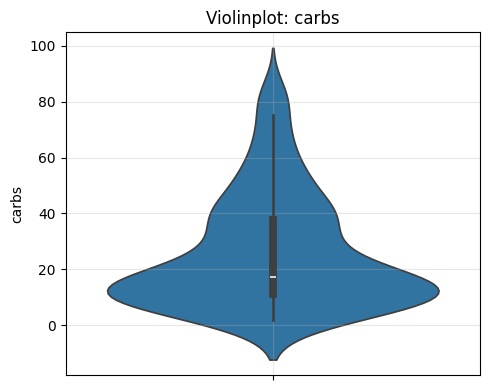

In [25]:
col = "carbs"
plt.figure(figsize=(5, 4))
sns.violinplot(y=data[col])
plt.title(f'Violinplot: {col}')
plt.ylabel(col)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

* clustermap — построенный на основе матрицы числовых признаков (например, после groupby по категориальному признаку с агрегацией, или на основе корреляций).


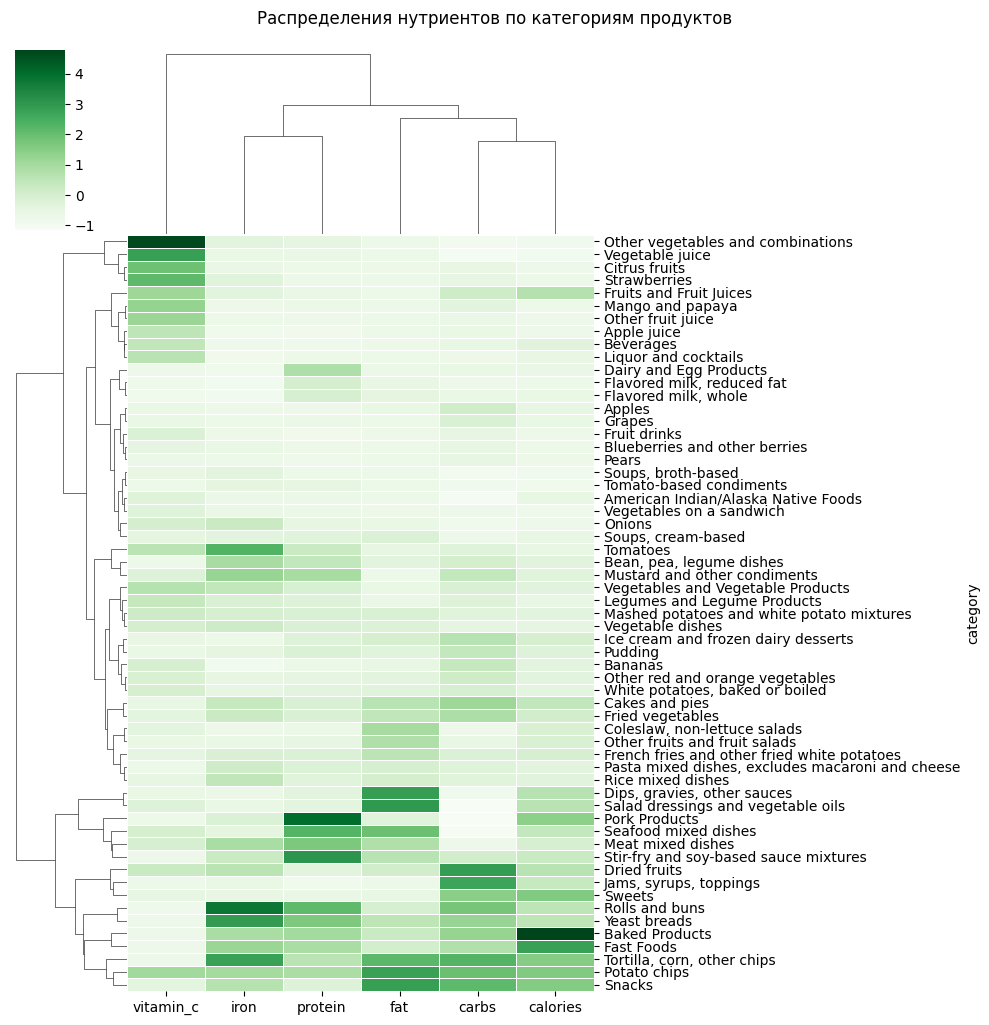

In [26]:
# 1. Агрегация по категориям
category_profile = data.groupby("category")[numeric_cols].mean()

# 2. Масштабирование (очень важно для clustermap!)
category_profile_scaled = (
    category_profile - category_profile.mean()
) / category_profile.std()

# category_profile_scaled -= category_profile_scaled.min()

# 3. Clustermap
sns.clustermap(
    category_profile_scaled,
    cmap="Greens",
    linewidths=0.5,
    figsize=(10, 10),
    method="ward",        # устойчивый метод кластеризации
    metric="euclidean",
    yticklabels=True
)

plt.suptitle(
    "Распределения нутриентов по категориям продуктов",
    y=1.02
)
plt.show()

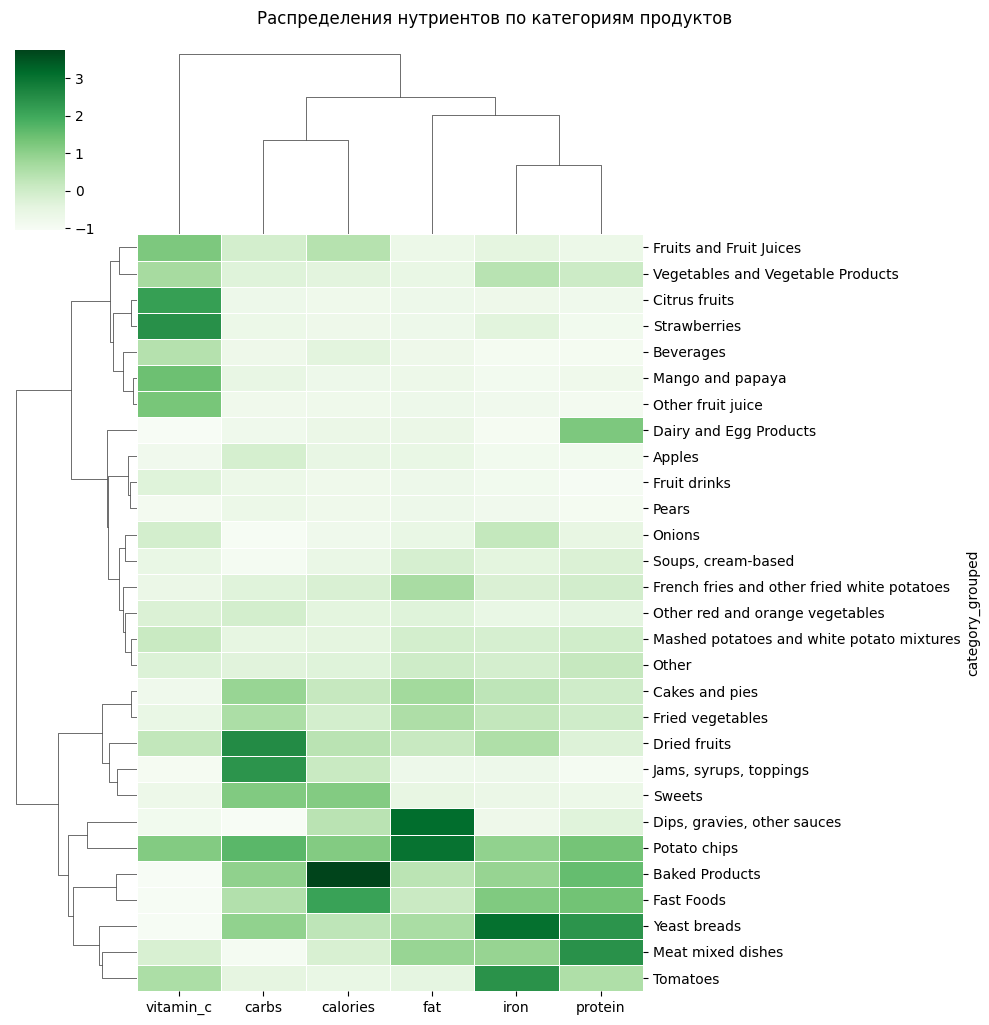

In [27]:
n = 2  # например: показываем категории с >3 продуктами

# считаем частоты категорий
category_counts = data["category"].value_counts()

# категории, которые оставляем
major_categories = category_counts[category_counts > n].index

# создаём новую колонку с объединением редких категорий
data_plot = data.copy()
data_plot["category_grouped"] = np.where(
    data_plot["category"].isin(major_categories),
    data_plot["category"],
    "Other"
)

# 1. Агрегация по категориям
category_profile = data_plot.groupby("category_grouped")[numeric_cols].mean()

# 2. Масштабирование (очень важно для clustermap!)
category_profile_scaled = (
    category_profile - category_profile.mean()
) / category_profile.std()

# category_profile_scaled -= category_profile_scaled.min()

# 3. Clustermap
sns.clustermap(
    category_profile_scaled,
    cmap="Greens",
    linewidths=0.5,
    figsize=(10, 10),
    method="ward",        # устойчивый метод кластеризации
    metric="euclidean",
    yticklabels=True
)

plt.suptitle(
    "Распределения нутриентов по категориям продуктов",
    y=1.02
)
plt.show()

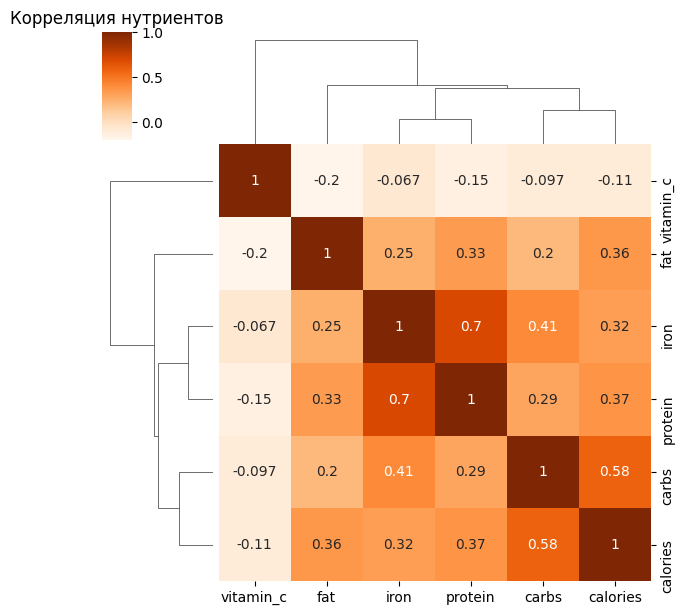

In [28]:
corr = data[numeric_cols].corr()

sns.clustermap(
    corr,
    cmap="Oranges",
    annot=True,
    figsize=(6, 6)
)
plt.title("Корреляция нутриентов")
plt.show()


## 6.	Интерпретация и выводы

* Какие признаки наиболее информативны?

Все признаки были полезны, кроме названия еды. 
Количство категорий еды слишком большое для такого маленького колличества блюд. Половина категорий есть только у одного - двух блюд.

* Есть ли признаки с высоким уровнем пропусков или аномалий?

Нет. Пропусков довольно мало. Аномалий нет.

* Как распределены категории?

* Как распределены категории в крупном категориальном признаке?

Половина категорий есть только у одного - двух блюд.
Черезмерное колличество категорий мешает воспринимать картину. Поэтому в некоторых местах я отображал только популярные категории.

* Какие кластеры выделяются на clustermap? Что они могут означать?

Коренное разделение на кластеры по вертикали делит продукты на:

Сверху - продукты растительного происхождения в сыром или варёном виде.

Снизу - продукты животного происхождения, а так же запечёные и жаренные продукты.

Можно отследить и другие групы, например: фрукты, овощи, мясо + рыба

* Какие гипотезы можно сформулировать на основе визуализаций?

По комбинации значений различных нутринов можно приблизительно определить из чего сделано блюдо, его основу.
